# Notebook version of QAOA

In [1]:
# Quantum Approximate Optimization Algorithm using Gate-based QC

# This Notebook acts as a host for Q# to implement Quantum Approximate Optimization Algorithm (QAOA) on a gate-based Quantum Computing model.

# Importing required libraries

# General imports
import time
from numpy import pi
import numpy as np
import matplotlib.pyplot as plt

# Libraries for Model Formulation
from docplex.mp.model import Model
from scipy.optimize import minimize
from collections import Counter

import qsharp
qsharp.init(project_root = 'C:/Users/londh/qc/QRISE_QRE/qaoa')

# Qiskit Imports
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.visualization import plot_histogram
from qiskit_optimization.translators import from_docplex_mp

# Library for circuit simulation
import pennylane as qml


In [2]:
# Function to sort the count dictionary.
def find_most_common_solutions(input_dict, n):
    sorted_keys = sorted(input_dict, key=input_dict.get, reverse=True)
    return sorted_keys[:n]


# Building the model and its Cost Function
 
# We are using ***docplex*** to build the model and calculate $Q$ and $c$.

def build_qubo(arr: list):

    n = len(arr)
    c = sum(arr)
    # Building the model and its QUBO formulation.
    model = Model()
    x = model.binary_var_list(n)

    Q =  (c - 2*sum(arr[i]*x[i] for i in range(n)))**2
    model.minimize(Q)   

    problem = from_docplex_mp(model)

    converter = QuadraticProgramToQubo()
    qubo = converter.convert(problem)
    # print(qubo)

    quadratics = qubo.objective.quadratic.coefficients
    linears = qubo.objective.linear.coefficients

    return quadratics, linears, qubo


In [3]:
# test_arr = [12,4,6]

# n_qubits = len(test_arr)
# layers = 3

# gamma = [0.2]
# beta = [0.2]

# #circuit(NQubits: Int, Layers: Int, gammas: Double[], betas: Double[], quadratics: Double[][], linears: Double[]) : Result[] {

# quadratics, linears , _ = build_qubo(test_arr)

# quadratics = quadratics.toarray().flatten()
# linears = linears.toarray()

# def arr_to_str(a):
#     string =''
#     for i in a:
#         string += str(i) + ","
#     return '[' + string + ']'

# input_str = f'{n_qubits},{layers},{gamma},{beta},{arr_to_str(quadratics)},{arr_to_str(linears[0])}'

# counts = qsharp.run(f"qaoa.circuit({input_str})",shots=1)

# print(counts)
# # print(counts[0][0],type(counts[0][0]))

In [4]:
%%qsharp
open Microsoft.Quantum.Convert;
/// # Description
/// This is a program for simulating the QAOA circuit. 
namespace qaoa_note {

    open Microsoft.Quantum.Arrays;
    open Microsoft.Quantum.Diagnostics;
    open Microsoft.Quantum.Measurement;

    // Function for getting flat index
    operation flat_index(n: Int, i: Int, j: Int): Int{
        return n*i +j
    }

    operation cost_unitary(qubits: Qubit[], gamma: Double, quadratics: Double[], linears: Double[]): Unit{
        
        let n_qubits = Length(linears);
        mutable quad_sum : Double = 0.0;
        // RZ Gates
        for qubit in 0..n_qubits-1{
            set quad_sum = 0.0;
            for quad_qubit in 0..n_qubits-1{
                set quad_sum += quadratics[flat_index(n_qubits,qubit,quad_qubit)];
            }
            Rz(0.5 * (linears[qubit] + quad_sum) * gamma, qubits[qubit])
        }
        // RZZ Gates
        for i in 0..n_qubits-1{
            for j in i+1..n_qubits-1{
                Rzz(0.25 * quadratics[flat_index(n_qubits,i,j)] * gamma, qubits[i], qubits[j])
            }
        }
    }

    operation mixer_unitary(qubits: Qubit[], beta: Double) : Unit{
        for qubit in qubits{
            Rx(2.0 * beta,qubit);
        }
    }

    operation circuit(NQubits: Int, Layers: Int, gammas: Double[], betas: Double[], quadratics: Double[], linears: Double[]) : Int {
        use q = Qubit[NQubits]; 
        mutable integer_result = 0;

        // Message($"quad {quadratics}");
        // Message($"lin {linears}");

        ApplyToEachA(H,q);

        for i in 0..Layers-1{
            // Message($"Layer {i}");
            mixer_unitary(q, betas[i]);
            cost_unitary(q, gammas[i], quadratics, linears)
            
        }
        // for i in 0..NQubits-1{
        //     let r = MResetZ(q[i]);
        //     // Message($"{r}");
            
        //     if r == One{
        //         set integer_result += 2^i;
        //     }
        // }

        // ResetAll(q);    

        // return integer_result;
        return MeasureInteger(q);

    }
}


In [5]:
test_arr = [12,4,6,4]

n_qubits = len(test_arr)
layers = 3

init_gamma = list(np.array([pi/1.6]*layers))
init_beta = list(np.array([pi/4]*layers))

#circuit(NQubits: Int, Layers: Int, gammas: Double[], betas: Double[], quadratics: Double[][], linears: Double[]) : Result[] {

quadratics, linears , _ = build_qubo(test_arr)

quadratics = quadratics.toarray().flatten()
linears = linears.toarray()

def arr_to_str(a):
    string =''
    for i in a:
        string += str(i) + ","
    return '[' + string + ']'

input_str = f'{n_qubits},{layers},{init_gamma},{init_beta},{arr_to_str(quadratics)},{arr_to_str(linears[0])}'

counts = qsharp.run(f"qaoa_note.circuit({input_str})",shots=100)

print(counts)
# print(counts[0][0],type(counts[0][0]))

[8, 1, 9, 11, 8, 14, 11, 13, 14, 8, 9, 9, 8, 15, 4, 1, 12, 4, 8, 7, 3, 5, 8, 1, 13, 14, 3, 8, 5, 13, 12, 15, 2, 11, 8, 8, 8, 6, 1, 4, 3, 7, 3, 1, 4, 9, 2, 3, 11, 10, 6, 2, 10, 5, 15, 10, 11, 12, 12, 6, 11, 11, 4, 1, 7, 0, 13, 12, 10, 12, 13, 3, 5, 4, 14, 6, 4, 4, 3, 15, 13, 6, 2, 10, 9, 14, 1, 12, 13, 10, 2, 3, 14, 1, 0, 10, 7, 11, 8, 13]


In [6]:
def interger_to_counts(n,result):
    counts = {}
    for i in range(2**n):
        counts[np.binary_repr(i,width=n)] = 0
    for integer in result:
        counts[np.binary_repr(integer,width=n)] += 1
    return counts

In [14]:
# ## Creating the QAOA circuit and layers.
# 
# I'm using ***Pennylane*** to handle the circuit simulations. I have created functions to generate the QAOA circuit given $Q$ and $c$.

func_call = 0
theta = []
cost = []

def callback_func(x):
    theta.append(x)

def qaoa(arr,layers:int):
    

    quadratics, linears, qubo = build_qubo(arr)
    num_qubits = len(arr)

    quadratics = quadratics.toarray().flatten()
    linears = linears.toarray()

    # Initial guess
    init_gamma = np.array([pi/1.5]*layers)
    init_beta = np.array([pi/4]*layers)
    initial_guess = np.concatenate((init_gamma, init_beta))
    
    def expectation_value(theta):
        global func_call 
        func_call = func_call + 1
        print(f'Function call: {func_call}')
        middle = int(len(theta)/2)
        gammas = theta[:middle]
        betas = theta[middle:]

        input_str = f"{num_qubits},{layers},{arr_to_str(gammas)},{arr_to_str(betas)},{arr_to_str(quadratics)},{arr_to_str(linears[0])}"

        int_results = qsharp.run(f"qaoa_note.circuit({input_str})",shots=100)
        counts = interger_to_counts(num_qubits,int_results)

        best_sol = max(counts, key=counts.get) # type: ignore
        exp =  qubo.objective.evaluate(np.array(list(best_sol), dtype='int'))
        cost.append(exp)
        return exp

    # Minimization of the objective function.
    start_time = time.time()
    res = minimize(expectation_value, initial_guess, method='COBYLA',callback=callback_func)
    # res = minimize(expectation_value, initial_guess, method='CG')
    end_time = time.time()
    elapsed_time = end_time - start_time

    print(f'Elapsed time for QAOA: {elapsed_time} seconds')

    middle = int(len(res.x)/2)
    prime_gammas = res.x[:middle]
    prime_betas = res.x[middle:]

    input_str = f"{num_qubits},{layers},{arr_to_str(prime_gammas)},{arr_to_str(prime_betas)},{arr_to_str(quadratics)},{arr_to_str(linears[0])}"

    results = qsharp.run(f"qaoa_note.circuit({input_str})",shots=1024)
    
    counts = interger_to_counts(num_qubits,results)
    
    return find_most_common_solutions(counts, 3)

In [10]:
test_array = [5,4,6,3]

layers = 3

result_state = qaoa(test_arr,layers)

result_state


Number of function calls: 1
Number of function calls: 2
Number of function calls: 3
Number of function calls: 4
Number of function calls: 5
Number of function calls: 6
Number of function calls: 7
Number of function calls: 8
Number of function calls: 9
Number of function calls: 10
Number of function calls: 11
Number of function calls: 12
Number of function calls: 13
Number of function calls: 14
Number of function calls: 15
Number of function calls: 16
Number of function calls: 17
Number of function calls: 18
Number of function calls: 19
Number of function calls: 20
Number of function calls: 21
Number of function calls: 22
Number of function calls: 23
Number of function calls: 24
Number of function calls: 25
Number of function calls: 26
Number of function calls: 27
Number of function calls: 28
Number of function calls: 29
Number of function calls: 30
Number of function calls: 31
Number of function calls: 32
Number of function calls: 33
Number of function calls: 34
Number of function call

['0101', '1010', '1011']

In [13]:
test_array = [5,4,6,3]

layers = 3

result_state = qaoa(test_arr,layers)

result_state


Number of function calls: 1
Number of function calls: 2
Number of function calls: 3
Number of function calls: 4
Number of function calls: 5
Number of function calls: 6
Number of function calls: 7
Number of function calls: 8
Number of function calls: 9
Number of function calls: 10
Number of function calls: 11
Number of function calls: 12
Number of function calls: 13
Number of function calls: 14
Number of function calls: 15
Number of function calls: 16
Number of function calls: 17
Number of function calls: 18
Number of function calls: 19
Number of function calls: 20
Number of function calls: 21
Number of function calls: 22
Number of function calls: 23
Number of function calls: 24
Number of function calls: 25
Number of function calls: 26
Number of function calls: 27
Number of function calls: 28
Number of function calls: 29
Number of function calls: 30
Number of function calls: 31
Number of function calls: 32
Number of function calls: 33
Number of function calls: 34
Number of function call

['1000', '1110', '0111']

In [15]:
test_array = [5,4,6,1]

layers = 3

result_state = qaoa(test_arr,layers)

print(result_state)


Function call: 1
Function call: 2
Function call: 3
Function call: 4
Function call: 5
Function call: 6
Function call: 7
Function call: 8
Function call: 9
Function call: 10
Function call: 11
Function call: 12
Function call: 13
Function call: 14
Function call: 15
Function call: 16
Function call: 17
Function call: 18
Function call: 19
Function call: 20
Function call: 21
Function call: 22
Function call: 23
Function call: 24
Function call: 25
Function call: 26
Function call: 27
Function call: 28
Function call: 29
Function call: 30
Function call: 31
Function call: 32
Function call: 33
Function call: 34
Function call: 35
Function call: 36
Function call: 37
Function call: 38
Function call: 39
Function call: 40
Function call: 41
Function call: 42
Function call: 43
Function call: 44
Function call: 45
Function call: 46
Function call: 47
Function call: 48
Function call: 49
Function call: 50
Function call: 51
Function call: 52
Function call: 53
Function call: 54
Function call: 55
Function call: 56
F

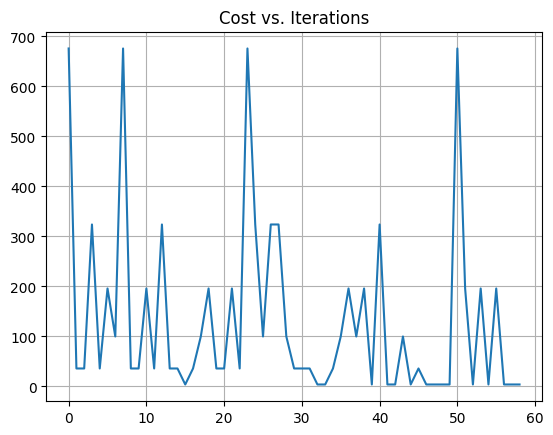

In [16]:

plt.plot(range(len(cost)),cost)
plt.grid()
plt.title('Cost vs. Iterations')
plt.show()